# Preprocessing for API retrieved property data

## Rental Price Preprocessing Appraoch Overview

We want to preprocess rental price for all instances into integers. In summary, we have found these type of price:

*Weekly rent only*

*   `520pw`
*   `$650.00 per week`
*   `$650 p.w.`
*   `$395 per week`
*   `$580 per weekly - Unfurnished`
*   `$160-$200 weekly`:

*Weekly + Monthly rent*

*   `$2300pw \ $9994pcm`
*    `545 PW \ $2368 PCM`
*    `$690pw\$2998pcm`

*Undefined rent* (will be assumed as weekly rent)
*   `$750 **SPACIOUS APARTMENT**`
*   `$320 OR $320.00` 
*   `$490 Fully Furnished`

*Others (will be dropped)*

*   `Contact Agent`: no value
*   `$2384 calendar month`: monthly rent
*   `$33,000 Per Year`: annual rent
*   `160 per night`
*   `1Bed + 1Study $560 Negotiable`

As we will only be analysising with weekly rent, we will use regular expression to extract the weekly rent. In general, we generated 4 types of regular expression:
*   --TYPE1-- **price value with `'w'`**: 
    *   The common characteristic betweem 'pw', 'per week', 'weekly' etc. is that they all have 'w' in their unit. Thus by extracting price followed by w, we can aviod extracting monthly rent.
*   --TYPE2--  **price value only**: 
    *   We assume if the price discription contains value only, it is the weekly rent.
*   --TYPE3-- **price value ended with `'d'`**: 
    *   From expirements, we discovered that there are many instances which didn't specify weekly rent however specified 'furnished' eg`$490 Fully Furnished`, we will assume these as weekly rent.
*   --TYPE4--**price value with `**discription**`**: 
    *   We also discovered many price looked like `$750 **SPACIOUS APARTMENT**`, hence we assume those are weekly rent.

In [83]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# RE version

In [80]:
df = pd.read_csv("../../data/raw/API_Raw_PropertiesInfo.csv")
df['price'] = df["price"].str.replace(",","")
df['price'] = df["price"].str.replace(" ","_") # replacing blank space with underline will simplify code in regex

regex_str1 = r'([$]?\d+[.]?\d+\w+[.]*\w*[/]*\w*[wW])' # $650.00 per week
regex_str2 = r'([$]?\d+[.]?\d+$)' # $320
regex_str3 = r'([$]?\d+[.]?\d+\w+[-]?\w+[d]$)' # $490 Fully Furnished
regex_str4 = r'([$]?\d+[.]?\d+\w*[*]+\w)' # $750_**SPACIOUS_APARTMENT**

df['price1']=df['price'].str.extract(regex_str1)
df['price2']=df['price'].str.extract(regex_str2)
df['price3']=df['price'].str.extract(regex_str3)
df['price4']=df['price'].str.extract(regex_str4)


In [81]:
df['weekly_rent'] = df['price4'].where(df['price4'].notnull(), df['price1'])
df['weekly_rent'] = df['weekly_rent'].where(df['weekly_rent'].notnull(), df['price2'])
df['weekly_rent'] = df['weekly_rent'].where(df['weekly_rent'].notnull(), df['price3'])
df = df.drop(['price1','price2','price3', 'price4'],axis=1)
#dff = df[['price', 'weekly_rent']]
#dff.to_csv("re.csv")
#dff1 = dff[dff['weekly_rent'].isna()] #just for checking
#dff1.to_csv('re_null.csv')
df2 = df.dropna(subset = ['weekly_rent'])
df2['weekly_rent'] = df2['weekly_rent'].str.extract('(\d+)').astype(int)

df3 = df2[df2['weekly_rent'] > 10000] # drop the yearly rent ones.
result =  df2[df2['weekly_rent'] < 10000]
result.to_csv("../../data/curated/API_re_clean.csv")

print(f'{len(df) - len(df2)} instances were dropped as no weekly rent was demonstrated')
print(f'{len(df3)} instances were dropped as it was annual rent')


<ipython-input-81-2d8494e564c3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['weekly_rent'] = df2['weekly_rent'].str.extract('(\d+)').astype(int)


482 instances were dropped as no weekly rent was demonstrated
1 instances were dropped as it was annual rent


(array([1.720e+02, 4.686e+03, 7.081e+03, 1.761e+03, 5.370e+02, 1.740e+02,
        1.050e+02, 5.500e+01, 3.700e+01, 2.900e+01, 8.000e+00, 6.000e+00,
        2.000e+01, 3.000e+00, 5.000e+00, 2.000e+00, 0.000e+00, 5.000e+00,
        4.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([1.00000000e+00, 2.00966667e+02, 4.00933333e+02, 6.00900000e+02,
        8.00866667e+02, 1.00083333e+03, 1.20080000e+03, 1.40076667e+03,
        1.60073333e+03, 1.80070000e+03, 2.00066667e+03, 2.20063333e+03,
        2.40060000e+03, 2.60056667e+03, 2.80053333e+03, 3.00050000e+03,
        3.20046667e+03, 3.40043333e+03, 3.60040000e+03, 3.80036667e+03,
        4.00033333e+03, 4.20030000e+03, 4.40026667e+03, 4.60023333e+03,
        4.80020000e+03, 5.00016667e+03, 5.20013333e+03, 5.40010000e+03,
        5.60006667e+03, 5.80003333e+03, 6.00000000e+03]),
 <BarContainer object of 30 artists>)

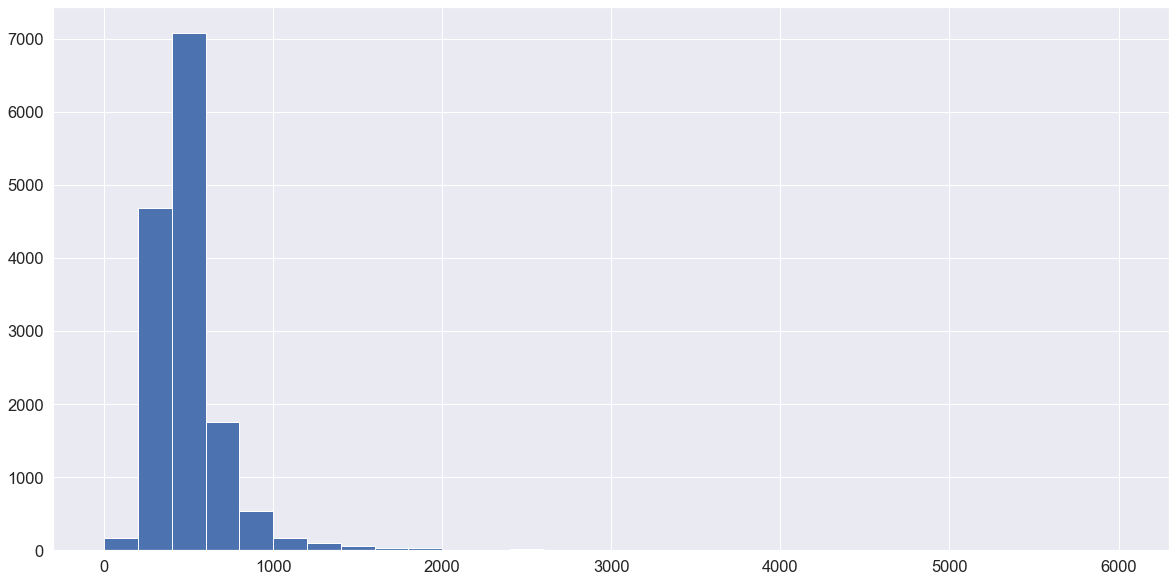

In [84]:
plt.hist(result['weekly_rent'], bins=30)

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 6.0000e+00, 0.0000e+00,
        2.4000e+01, 0.0000e+00, 5.0000e+00, 0.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 8.0000e+00, 0.0000e+00, 2.7000e+01,
        0.0000e+00, 4.6000e+01, 0.0000e+00, 7.6000e+01, 0.0000e+00,
        2.2700e+02, 0.0000e+00, 3.8200e+02, 0.0000e+00, 1.3888e+04]),
 array([2008.        , 2008.46666667, 2008.93333333, 2009.4       ,
        2009.86666667, 2010.33333333, 2010.8       , 2011.26666667,
        2011.73333333, 2012.2       , 2012.66666667, 2013.13333333,
        2013.6       , 2014.06666667, 2014.53333333, 2015.        ,
        2015.46666667, 2015.93333333, 2016.4       , 2016.86666667,
        2017.33333333, 2017.8       , 2018.26666667, 2018.73333333,
        2019.2       , 2019.66666667, 2020.13333333, 2020.6       ,
        2021.06666667, 2021.53333333, 2022.        ]),
 <BarContainer object of 30 artists>)

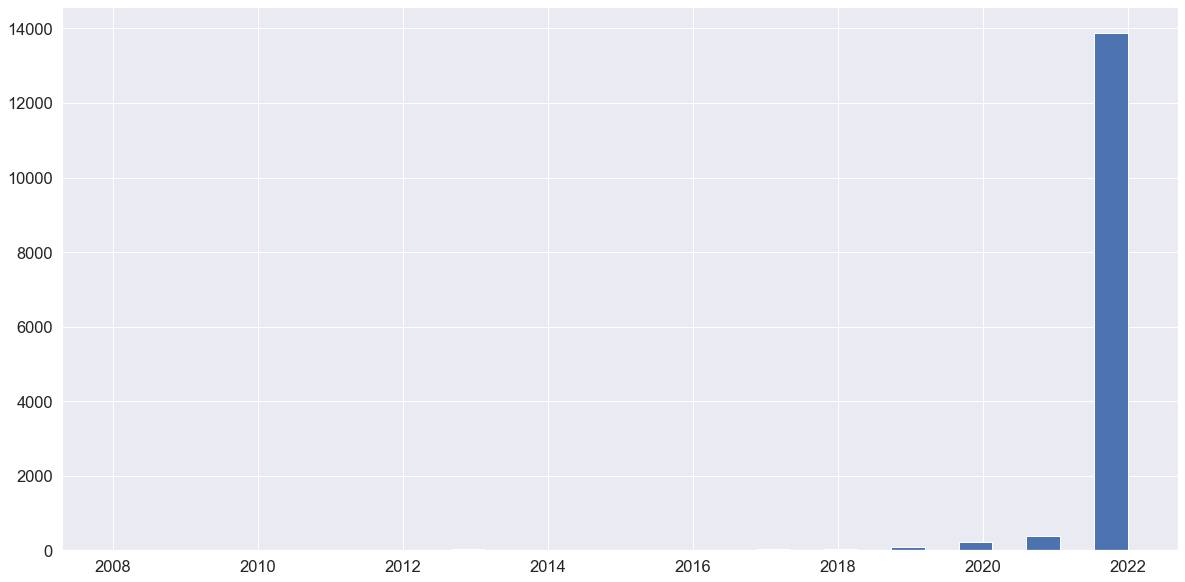

In [85]:

# pd.Timestamp(result['time_listed'])
#result['time_listed'].to_timestamp()

df2 = pd.to_datetime(result['time'])
years = df2.dt.year
years
plt.hist(years, bins=30)

In [86]:
print(set(result.property_type))

{'SemiDetached', 'ApartmentUnitFlat', 'Duplex', 'Studio', 'Townhouse', 'Rural', 'NewHouseLand', 'Penthouse', 'Terrace', 'CarSpace', 'Villa', 'NewApartments', 'House', 'AcreageSemiRural'}


In [87]:
property_type = result[['property_type', 'weekly_rent','postcode']] \
                .groupby(['property_type'],as_index = False) \
                .agg(
                    {\
                        'weekly_rent': 'mean', # count number of instances from sample
                        'postcode': 'count'
                    }
                ) \
                .rename({'postcode': 'num','weekly_rent': 'averaged_wk_rent' }, axis=1)

property_type

,property_type,averaged_wk_rent,num
0,AcreageSemiRural,801.428571,14
1,ApartmentUnitFlat,474.964988,5798
2,CarSpace,50.000000,1
3,Duplex,546.000000,5
4,House,532.665825,7125
5,NewApartments,476.833333,6
6,NewHouseLand,435.000000,2
7,Penthouse,825.000000,1
8,Rural,1000.000000,1
9,SemiDetached,673.125000,8


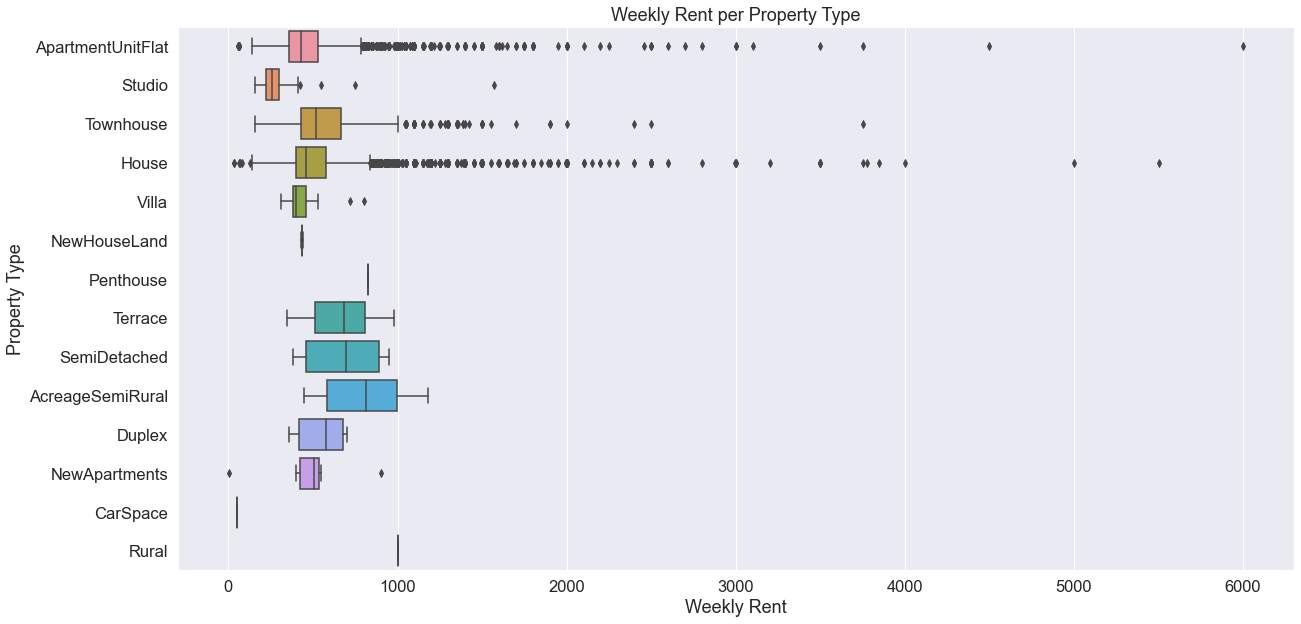

In [96]:
import seaborn as sns
from matplotlib import pyplot
import os
newpath = r'../../plots/figure/' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

#sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale=1.5)

size = (20,10)
fig, ax = pyplot.subplots(figsize=size)
b = sns.boxplot(ax=ax, data=result, x="weekly_rent", y="property_type")
b.axes.set_title("Weekly Rent per Property Type")
b.set_xlabel("Weekly Rent")
b.set_ylabel("Property Type")
b.figure.savefig("../../plots/figure/API_Rent_per_Property_Type.png")

In [123]:
# classify types of properties
house = ['Villa', 'NewHouseLand', 'Townhouse', 'Duplex', 'House', 'Terrace', 'SemiDetached']
apartment = ['ApartmentUnitFlat', 'Studio', 'NewApartments', 'Penthouse']
rural = ['Rural', 'AcreageSemiRural']

# initialise geo spatial dataframe for each type of property
df = result
house_df0 = df[df.property_type.isin(house)]
apartment_df0 = df[df.property_type.isin(apartment)]
rural_df0 = df[df.property_type.isin(rural)]

## Further rental price preprocess for Apartment Type properties

For apartmemts where weekly rental price is less than 100, though the property_type was labelled as 'ApartmentUnitFlat', we can tell the property type should be car parks. Hence, we eliminate these instances as they are outliers.

In [124]:
apartment_df = apartment_df0
apartment_df[apartment_df.weekly_rent < 100]

,id,time,listing_type,price,property_type,area,building_area,land_area,bedrooms,bathrooms,carspaces,street_address,suburb,postcode,latitude,longitude,weekly_rent
121,16053002,2022-08-23T12:24:07,Rent,$55_per_week,ApartmentUnitFlat,Melbourne City Council - Greater Area,0.0,0.0,1.0,1.0,1,"CARPARK/200 Spencer Street, Melbourne",MELBOURNE,3000,-37.816300,144.953171,55
134,16040432,2022-08-16T10:21:16,Rent,$60_per_week,ApartmentUnitFlat,Melbourne City Council - Greater Area,0.0,0.0,1.0,1.0,1,"7021Y/220 Spencer Street, Melbourne",MELBOURNE,3000,-37.815716,144.952957,60
144,16018333,2022-08-02T16:06:22,Rent,$55_per_week,ApartmentUnitFlat,Melbourne City Council - Greater Area,0.0,0.0,1.0,1.0,1,"Carpark/33 Rose Lane, Melbourne",MELBOURNE,3000,-37.815440,144.954041,55
173,15955831,2022-06-27T15:18:24,Rent,$60_per_week,ApartmentUnitFlat,Melbourne City Council - Greater Area,0.0,0.0,1.0,1.0,1,"215/181 Exhibition Street, Melbourne",MELBOURNE,3000,-37.811455,144.970062,60
175,15919318,2022-06-06T09:07:09,Rent,$60_per_week,ApartmentUnitFlat,Melbourne City Council - Greater Area,0.0,0.0,1.0,1.0,1,"110/68 La Trobe Street, Melbourne",MELBOURNE,3000,-37.808365,144.966800,60
176,15858295,2022-04-28T18:00:30,Rent,$60_per_week,ApartmentUnitFlat,Melbourne City Council - Greater Area,0.0,0.0,1.0,1.0,1,"CARPARK/442 Elizabeth Street, Melbourne",MELBOURNE,3000,-37.808353,144.960724,60
321,15920687,2022-06-06T14:54:08,Rent,$60_per_week,ApartmentUnitFlat,Melbourne City Council - Greater Area,0.0,0.0,1.0,1.0,1,"8092Y/33 Rose Lane, Melbourne",MELBOURNE,3000,-37.815014,144.953873,60
322,15841654,2022-04-19T14:21:17,Rent,$65_per_week,ApartmentUnitFlat,Melbourne City Council - Greater Area,0.0,0.0,1.0,1.0,1,"285 La Trobe Street, Melbourne",MELBOURNE,3000,-37.810734,144.960815,65
10508,11296097,2017-04-05T14:30:34,Rent,$1.00,NewApartments,Port Philip City Council - Greater Area,0.0,0.0,2.0,1.0,0,"18 ANY Street, Elwood",ELWOOD,3184,-37.883710,144.989655,1


In [91]:
apartment_df = apartment_df[apartment_df.weekly_rent > 100]

<AxesSubplot:xlabel='property_type', ylabel='weekly_rent'>

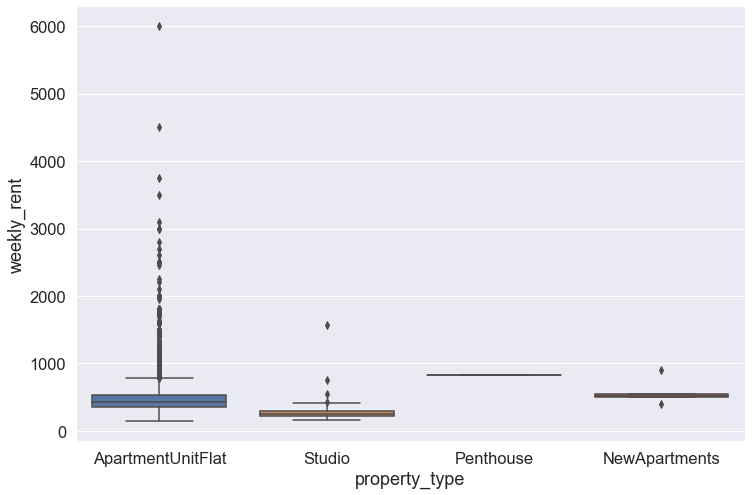

In [98]:
plt.rcParams["figure.figsize"] = (12, 8)
sns.boxplot(data = apartment_df, x='property_type', y = 'weekly_rent')

From the above boxplot, we could see there are some apartment whose weekly rent is greater than 3000. Hence we extract the whole information of these instances to see whether they are outliers.

In [99]:
apartment_df[apartment_df.weekly_rent > 3000]

,id,time,listing_type,price,property_type,area,building_area,land_area,bedrooms,bathrooms,carspaces,street_address,suburb,postcode,latitude,longitude,weekly_rent
60,15939303,2022-06-16T20:06:19,Rent,$4500_Per_Week,ApartmentUnitFlat,Melbourne City Council - Greater Area,0.0,0.0,3.0,2.0,4,"4203/35 Spring Street, Melbourne",MELBOURNE,3000,-37.814170,144.974000,4500
179,15631154,2022-01-05T18:50:50,Rent,$3100_per_week,ApartmentUnitFlat,Melbourne City Council - Greater Area,0.0,0.0,3.0,2.0,1,"7302/462 Elizabeth Street, Melbourne",MELBOURNE,3000,-37.807857,144.960617,3100
7043,15954871,2022-06-27T12:03:11,Rent,$3500_Per_Week,ApartmentUnitFlat,Boroondara City Council - Greater Area,0.0,0.0,5.0,4.0,2,"603/862 Glenferrie Road, Hawthorn",HAWTHORN,3122,-37.815530,145.036900,3500
10150,16002767,2022-07-25T12:48:22,Rent,$6000,ApartmentUnitFlat,Port Philip City Council - Greater Area,0.0,0.0,3.0,3.0,3,"3502/14-16 The Esplanade, St Kilda",ST KILDA,3182,-37.865017,144.974686,6000
11429,14089455,2020-03-17T16:56:47,Rent,$3750.00_per_week,ApartmentUnitFlat,Port Philip City Council - Greater Area,0.0,0.0,3.0,3.0,1,"901 & 902/85 Market Street, South Melbourne",SOUTH MELBOURNE,3205,-37.830116,144.956909,3750


From the above information, we could tell these apartments are relatively large with adequate number of bedrooms, bathrooms, and carspaces. Thus, those luxurious prices may be reasonable by intuition. Additionally, we googled the above address and double confirmed that the above information are accurate. Hence they will not be viewed as outliers. 

<AxesSubplot:>

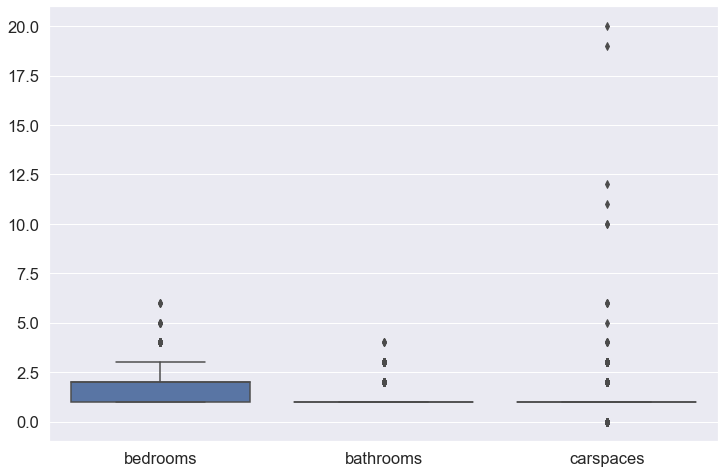

In [102]:
sns.boxplot(data = apartment_df[['bedrooms', 'bathrooms', 'carspaces']])

From the above boxplot, we can see that the number of bedrooms and bathrooms are within a normal range. However, many outliers for carspaces. Hence, we will extract and view the whole information for the uncommon carspaces instances

In [103]:
apartment_df[apartment_df.carspaces > 3]

,id,time,listing_type,price,property_type,area,building_area,land_area,bedrooms,bathrooms,carspaces,street_address,suburb,postcode,latitude,longitude,weekly_rent
60,15939303,2022-06-16T20:06:19,Rent,$4500_Per_Week,ApartmentUnitFlat,Melbourne City Council - Greater Area,0.0,0.0,3.0,2.0,4,"4203/35 Spring Street, Melbourne",MELBOURNE,3000,-37.814170,144.974000,4500
2004,10621148,2016-06-09T18:26:48,Rent,From_$786_-_$1572_per_week,Studio,Brimbank City Council - Greater Area,0.0,0.0,1.0,1.0,19,"1A & 1B/101-103 Main Road West, St Albans",ST ALBANS,3021,-37.756203,144.811249,1572
3575,16062401,2022-08-29T16:26:27,Rent,$420_per_week,ApartmentUnitFlat,Brimbank City Council - Greater Area,0.0,0.0,3.0,1.0,6,"44 Lackenheath Drive, Tullamarine",TULLAMARINE,3043,-37.695940,144.885300,420
7333,8431378,2021-07-20T08:51:30,Rent,APPLY_NOW_-_From_$420_per_week,ApartmentUnitFlat,Monash City - Greater Area,0.0,0.0,1.0,1.0,12,"224 Burwood Highway, Burwood",BURWOOD,3125,-37.850210,145.114400,420
7363,8431381,2022-01-27T10:29:54,Rent,APPLY_NOW_-_From_$230_per_week,ApartmentUnitFlat,Monash City - Greater Area,0.0,0.0,1.0,1.0,4,"216 Burwood Highway, Burwood",BURWOOD,3125,-37.850080,145.113400,230
7387,8431379,2013-06-28T23:13:59,Rent,APPLY_NOW_-_Studio_From_$250/w_&_2_Bed_From_$3...,ApartmentUnitFlat,Monash City - Greater Area,0.0,0.0,1.0,1.0,11,"308 Burwood Highway, Burwood",BURWOOD,3125,-37.851000,145.120911,250
7388,8431375,2013-06-28T23:13:45,Rent,APPLY_NOW_-_From_$210_per_week,ApartmentUnitFlat,Monash City - Greater Area,0.0,0.0,1.0,1.0,20,"390 Burwood Highway, Burwood",BURWOOD,3125,-37.852120,145.130900,210
7478,15974418,2022-07-07T13:31:15,Rent,$620.00,ApartmentUnitFlat,Boroondara City Council - Greater Area,0.0,0.0,3.0,2.0,4,"1/1041 Riversdale Road, Surrey Hills",SURREY HILLS,3127,-37.836840,145.105423,620
7563,8431394,2021-07-19T16:55:12,Rent,APPLY_NOW_-_From_$180_per_week,ApartmentUnitFlat,Whitehorse City Council - Greater Area,0.0,0.0,1.0,1.0,6,"484 Elgar Road, Box Hill",BOX HILL,3128,-37.813377,145.116074,180
7564,8431392,2021-07-19T16:38:43,Rent,APPLY_NOW_-_From_$190_per_week,ApartmentUnitFlat,Whitehorse City Council - Greater Area,0.0,0.0,1.0,1.0,10,"14 Spring Street, Box Hill",BOX HILL,3128,-37.815450,145.118317,190


From the above information, we discovered that some apartment are big and luxurious and therefore it is normal for them to have more than 4 car spaces.

However, for some apartment eg. 224 Burwood Highway, Burwood, 224 Burwood Highway, Burwood etc., they are small (1B1B) however with a large number of carspaces (more than 6). As the rental price are normal (they did not charge extra for car spaces), we will view them as outliers.

In [111]:
id = apartment_df[(apartment_df.carspaces > 6) & (apartment_df.bedrooms == 1.0) & (apartment_df.bathrooms == 1.0)].id
id_lst = list(id)

In [115]:
id_lst

[10621148, 8431378, 8431379, 8431375, 8431392, 8431393]

In [ ]:
house_df = df[df.property_type.isin(house)]

In [118]:
apartment_df.head()

,id,time,listing_type,price,property_type,area,building_area,land_area,bedrooms,bathrooms,carspaces,street_address,suburb,postcode,latitude,longitude,weekly_rent
0,16066003,2022-08-31T13:00:15,Rent,$320,ApartmentUnitFlat,Melbourne City Council - Greater Area,0.0,0.0,1.0,1.0,0,"1007/238 Flinders St, Melbourne",MELBOURNE,3000,-37.817516,144.966492,320
1,16065974,2022-08-31T12:50:55,Rent,$700,ApartmentUnitFlat,Melbourne City Council - Greater Area,0.0,0.0,2.0,2.0,0,"1211/260 Spencer Street, Melbourne",MELBOURNE,3000,-37.814564,144.952286,700
2,15302782,2022-08-31T10:12:30,Rent,$395_per_week,ApartmentUnitFlat,Melbourne City Council - Greater Area,0.0,0.0,2.0,1.0,0,"504/350 La Trobe Street, Melbourne",MELBOURNE,3000,-37.810680,144.959274,395
3,16064379,2022-08-30T15:20:28,Rent,$370_per_week,ApartmentUnitFlat,Melbourne City Council - Greater Area,0.0,0.0,1.0,1.0,0,"1106/555 Flinders Street, Melbourne",MELBOURNE,3000,-37.820972,144.956482,370
4,16064243,2022-08-30T14:50:32,Rent,$500_per_week,ApartmentUnitFlat,Melbourne City Council - Greater Area,0.0,0.0,2.0,1.0,1,"2901/200 Spencer Street, Melbourne",MELBOURNE,3000,-37.816227,144.953247,500


In [125]:
apartment_df = apartment_df[~apartment_df.id.isin(id_lst)]
print(f'In total {len(apartment_df0) -len(apartment_df)} instances were dropped in terms of rental price and number of car spaces')

In total 6 instances were dropped in terms of rental price and number of car spaces


### Formatting API data as web scraped historical data

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("../../data/curated/API_clean_price_with_SA2_using_geolocation.csv")

In [4]:
df.columns

Index(['Unnamed: 0', 'id', 'time', 'listing_type', 'price', 'property_type',
       'area', 'building_area', 'land_area', 'bedrooms', 'bathrooms',
       'carspaces', 'street_address', 'suburb', 'postcode', 'latitude',
       'longitude', 'weekly_rent', 'SA2_CODE'],
      dtype='object')

In [11]:
df.dates = pd.to_datetime(df.time)
df['year'] = df.dates.dt.year # add year column
df['month'] = df.dates.dt.month # add month column

<ipython-input-11-13e4fcf80246>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.dates = pd.to_datetime(df.time)


In [24]:
df2 = pd.read_csv("/Users/graceliu/generic-real-estate-consulting-project-group-43/data/curated/historical/2006_historical_clean.csv")
df2.columns

Index(['Unnamed: 0', 'address', 'latitude', 'longitude', 'nbed', 'nbath',
       'ncar', 'price', 'type', 'historical_dates', 'postcode', 'year',
       'month', 'suburb', 'weekly_rent'],
      dtype='object')

In [15]:
df.columns

Index(['Unnamed: 0', 'id', 'time', 'listing_type', 'price', 'property_type',
       'area', 'building_area', 'land_area', 'bedrooms', 'bathrooms',
       'carspaces', 'street_address', 'suburb', 'postcode', 'latitude',
       'longitude', 'weekly_rent', 'SA2_CODE', 'year', 'month'],
      dtype='object')

In [16]:
lst = ['street_address', 'latitude', 'longitude', 'bedrooms', 'bathrooms', 'carspaces', 'price', 'listing_type', 'time', 'postcode', 'year', 'month', 'suburb', 'weekly_rent']
df = df[lst]

In [17]:
df

,street_address,latitude,longitude,bedrooms,bathrooms,carspaces,price,listing_type,time,postcode,year,month,suburb,weekly_rent
0,"1007/238 Flinders St, Melbourne",-37.817516,144.966492,1.0,1.0,0,$320,Rent,2022-08-31 13:00:15,3000,2022,8,MELBOURNE,320
1,"1211/260 Spencer Street, Melbourne",-37.814564,144.952286,2.0,2.0,0,$700,Rent,2022-08-31 12:50:55,3000,2022,8,MELBOURNE,700
2,"504/350 La Trobe Street, Melbourne",-37.810680,144.959274,2.0,1.0,0,$395_per_week,Rent,2022-08-31 10:12:30,3000,2022,8,MELBOURNE,395
3,"1106/555 Flinders Street, Melbourne",-37.820972,144.956482,1.0,1.0,0,$370_per_week,Rent,2022-08-30 15:20:28,3000,2022,8,MELBOURNE,370
4,"2901/200 Spencer Street, Melbourne",-37.816227,144.953247,2.0,1.0,1,$500_per_week,Rent,2022-08-30 14:50:32,3000,2022,8,MELBOURNE,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14689,"2/34a Freda Street, Inverloch",-38.633750,145.721924,3.0,2.0,2,$600.00_Per_Week,Rent,2022-07-20 15:14:20,3996,2022,7,INVERLOCH,600
14690,"28 Beachcomber Drive, Inverloch",-38.641250,145.703125,4.0,2.0,0,$550_wk,Rent,2022-06-06 13:32:31,3996,2022,6,INVERLOCH,550
14691,"14 Inverloch Parade, Inverloch",-38.628716,145.735809,2.0,1.0,0,$420_wk,Rent,2022-08-16 09:48:35,3996,2022,8,INVERLOCH,420
14692,"10 Hopetoun Street, Inverloch",-38.634125,145.730682,2.0,1.0,1,$370_wk,Rent,2022-08-02 12:20:31,3996,2022,8,INVERLOCH,370


In [18]:
df = df.rename(columns = {'street_address': 'address', 'bedrooms': 'nbed', 'bathrooms': 'nbath', 'carspaces': 'ncar', 'listing_type': 'type', 'time': 'historical_dates'})

In [26]:
df.to_csv("../../data/curated/API_re_clean.csv")

In [27]:
df

,address,latitude,longitude,nbed,nbath,ncar,price,type,historical_dates,postcode,year,month,suburb,weekly_rent
0,"1007/238 Flinders St, Melbourne",-37.817516,144.966492,1.0,1.0,0,$320,Rent,2022-08-31 13:00:15,3000,2022,8,MELBOURNE,320
1,"1211/260 Spencer Street, Melbourne",-37.814564,144.952286,2.0,2.0,0,$700,Rent,2022-08-31 12:50:55,3000,2022,8,MELBOURNE,700
2,"504/350 La Trobe Street, Melbourne",-37.810680,144.959274,2.0,1.0,0,$395_per_week,Rent,2022-08-31 10:12:30,3000,2022,8,MELBOURNE,395
3,"1106/555 Flinders Street, Melbourne",-37.820972,144.956482,1.0,1.0,0,$370_per_week,Rent,2022-08-30 15:20:28,3000,2022,8,MELBOURNE,370
4,"2901/200 Spencer Street, Melbourne",-37.816227,144.953247,2.0,1.0,1,$500_per_week,Rent,2022-08-30 14:50:32,3000,2022,8,MELBOURNE,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14689,"2/34a Freda Street, Inverloch",-38.633750,145.721924,3.0,2.0,2,$600.00_Per_Week,Rent,2022-07-20 15:14:20,3996,2022,7,INVERLOCH,600
14690,"28 Beachcomber Drive, Inverloch",-38.641250,145.703125,4.0,2.0,0,$550_wk,Rent,2022-06-06 13:32:31,3996,2022,6,INVERLOCH,550
14691,"14 Inverloch Parade, Inverloch",-38.628716,145.735809,2.0,1.0,0,$420_wk,Rent,2022-08-16 09:48:35,3996,2022,8,INVERLOCH,420
14692,"10 Hopetoun Street, Inverloch",-38.634125,145.730682,2.0,1.0,1,$370_wk,Rent,2022-08-02 12:20:31,3996,2022,8,INVERLOCH,370
